# Scikit-learn active learning loop: Spanish

Maxine Hofstetter

sources:
https://towardsdatascience.com/use-active-learning-to-boost-your-ml-problem-53c70f72b979
sklearn: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
https://docs.rubrix.ml/en/stable/tutorials/05-active_learning.html
https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html


## 1) Imports

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import  preprocessing
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## 2) helper functions

In [92]:
def get_class_dist(df_col):
    """
    plot label distribution
    """
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90,horizontalalignment='right')


In [93]:
def get_balanced_set(df):
    """
    create balanced data set (oversampling)
    """
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)


In [94]:
def get_flattened_list(nested_list):
    """
    flatten a list of lists
    """
    return [item for sublist in nested_list for item in sublist]


In [95]:
def get_learners_preds(prediction_proba):
    """
    return the learners predictions as a dict with the labels as keys and the probabilities as values
    :param prediction_proba: values obtained from learner.predict()
    :return: dict with probability per label
    """
    prediction_proba = np.round(prediction_proba, 2)
    prediction_list = list()
    for i in range(len(prediction_proba)):
        predictions = {'expl:immpers': prediction_proba[i][0], 'expl:pass': prediction_proba[i][1],
                      'expl:pv': prediction_proba[i][2], 'iobj': prediction_proba[i][3], 'obj': prediction_proba[i][4]}
        prediction_list.append(predictions)
    return prediction_list


## 3) load and preprocess data
- pool: unlabeled data (Corpus del Español)


In [96]:
train_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt'
test_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt'
dev_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-dev.txt'
pool_path = '/Users/Maxine/Desktop/se_corpus/CORPUSDATA_ORG/sp_text_se_corpus.txt'

train = pd.read_csv(train_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) 
train.drop(columns=['text'], inplace = True)
dev = pd.read_csv(dev_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)
test = pd.read_csv(test_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

se_corpus = pd.concat([train, dev, test]) # because the data was filtered for 'se' the data splits are not reliable anymore
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'flat')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'fixed')].index)

pool = pd.read_csv(pool_path, sep='\t', names=['text']) 


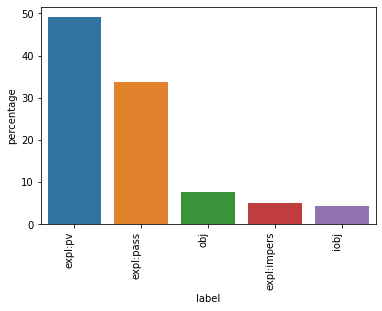

In [7]:
get_class_dist(se_corpus.se_label)


In [ ]:
# create data splits
X_train, X_test, y_train, y_test = train_test_split(se_corpus.tokenized_text.values, se_corpus.se_label.values,test_size=0.2,random_state=2022, stratify=se_corpus.se_label.values)

initial_train = pd.DataFrame(data={'tokenized_text': X_train, 'se_label': y_train}) # rebuild df
test = pd.DataFrame(data={'tokenized_text': X_test, 'se_label': y_test})

balanced_train = get_balanced_set(initial_train) # create oversampled training set

print('size train set: ', initial_train.shape, '\nsize oversampled train set: ', balanced_train.shape)
print('size test set: ', test.shape)


In [98]:
# preprocess data
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(initial_train.tokenized_text)
X_balanced_train = vectorizer.transform(balanced_train.tokenized_text)
X_test = vectorizer.transform(test.tokenized_text)
X_pool = vectorizer.transform(pool.text)

y_train = label_encoder.fit_transform(initial_train.se_label)
y_balanced_train = label_encoder.transform(balanced_train.se_label)
y_test = label_encoder.transform(test.se_label)


In [99]:
# check assigned values
print(list(label_encoder.classes_), label_encoder.transform(['expl:impers', 'expl:pass', 'expl:pv', 'iobj', 'obj']))


['expl:impers', 'expl:pass', 'expl:pv', 'iobj', 'obj'] [0 1 2 3 4]


## 4) Model
- check accuracy values of different classifiers
- check influence of parameter class_weight= ‘balanced’


In [22]:
models = [
    LinearSVC(multi_class='ovr'),
    LinearSVC(multi_class='ovr', class_weight='balanced'),
    LogisticRegression(max_iter=1000),
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    MultinomialNB(fit_prior=True),
]

cross_val = 10

df_cross_val = pd.DataFrame(index=range(cross_val * len(models)))
performances = []

for model in models:
    parameters = model.get_params()
    if 'class_weight' in parameters.keys():
        if parameters['class_weight'] == 'balanced':
            model_name = model.__class__.__name__ + '_balanced'
        else:
            model_name = model.__class__.__name__
    else:
        model_name = model.__class__.__name__
    f1_scores = cross_val_score(model,X_train, y_train, scoring='f1_weighted',cv=cross_val)
    for fold_index, f1_score in enumerate(f1_scores):
        performances.append((model_name, fold_index, f1_score))

df_cross_val = pd.DataFrame(performances, columns=['model', 'fold_index', 'f1_score_weighted'])
print(df_cross_val.groupby('model').f1_score_weighted.mean())


model
LinearSVC                      0.507448
LinearSVC_balanced             0.508176
LogisticRegression             0.509854
LogisticRegression_balanced    0.513067
MultinomialNB                  0.498094
Name: f1_score_weighted, dtype: float64


In [25]:
# choose best-performing classifier to evaluate on test set (baseline)

targets = label_encoder.classes_

clf = LogisticRegression(max_iter=1000)
clf.fit(X_balanced_train, y_balanced_train)

y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=targets, zero_division=0))


              precision    recall  f1-score   support

 expl:impers       0.38      0.20      0.26        44
   expl:pass       0.52      0.52      0.52       287
     expl:pv       0.60      0.72      0.65       417
        iobj       0.08      0.03      0.04        37
         obj       0.35      0.14      0.20        65

    accuracy                           0.55       850
   macro avg       0.38      0.32      0.33       850
weighted avg       0.52      0.55      0.53       850



## 5) Active Learner

In [100]:
# Initialize the ActiveLearner with the fitted classifier
learner = ActiveLearner(estimator=LogisticRegression(max_iter=10000),
                        query_strategy=uncertainty_sampling,
                        X_training=X_balanced_train,
                        y_training=y_balanced_train
                        )


In [ ]:
#convert X_pool (scipy matrix) to numpy array
X_pool = X_pool.toarray()


In [124]:
# define variables for loop
number_of_loops = 10
n_instances = 20 # number of samples to be queried in each loop
accuracies = [learner.score(X_test, y_test)] # append first accuracy without learning
pool_sent_list= list() # to store annotated sentences
pool_label_list= list() # to store annotated labels


### Loop
- annotate sentences that should be discarded with 'None'

In [ ]:
for i in range(number_of_loops):

    # query new samples
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    predicted_proba = get_learners_preds(learner.predict_proba(X_pool[query_idx]))
    sentences = pool.text.iloc[query_idx]

    # label the queried samples
    annotation = list()
    counter = 0
    for sent, proba in zip(sentences, predicted_proba):
        counter += 1
        sorted_proba = sorted(proba.items(), key=lambda kv: kv[1], reverse=True)
        prompt = '\n'+'loop: '+str(i+1)+'\n'+'sentence: '+str(counter)+'\n'+'The learners predictions are:'+'\n'+str(sorted_proba)+'\n\n'+sent+'\n'
        label = str(input(prompt))
        annotation.append(label)
    
    # keep track of labels
    sent_list = sentences.to_list()
    pool_sent_list.append(sent_list)
    pool_label_list.append(annotation)

    # filter out sentences that were assigned 'None'
    if 'None' in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample == 'None']
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter('None'.__ne__, annotation))


    # teach the learner
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool)
    accuracies.append(learner.score(X=X_test, y=y_test))

    # delete queried samples from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)



loop: 1
sentence: 1
The learners predictions are:
[('expl:pv', 0.27), ('iobj', 0.23), ('obj', 0.21), ('expl:pass', 0.15), ('expl:immpers', 0.13)]

No estoy de acuerdo con los pensamientos de algunos científicos , filósofos e inteligentes hombres de todos los tiempos donde se niega la existencia de un Dios que relacionan directamente con la religión y cometen un error , no puedo creer en religiones pero si en un ser supremo .
None


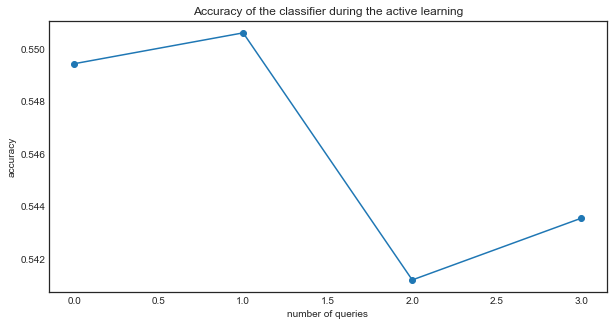

In [128]:
# plot learning curve
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    plt.title('Active learning loop')
    plt.plot(range(number_of_loops+1), accuracies)
    plt.scatter(range(number_of_loops+1), accuracies)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 11, 1))
    plt.xlabel('loop number')
    plt.ylabel('accuracy')
    plt.tight_layout()
    plt.show()


In [71]:
# highest achieved accuracy
print(max(accuracies))


0.8


In [130]:
# create df from annotations
sent_flattened = get_flattened_list(pool_sent_list)
label_flattened = get_flattened_list(pool_label_list)

labeled_pool = pd.DataFrame(list(zip(sent_flattened, label_flattened)),
               columns =['text', 'se_label'])
print(labeled_pool.shape)
print(labeled_pool.head())


(9, 2)
                                                text     se_label
0  Y no es por falta de ganas , pero cuando se tr...  expl:impers
1  La tesis de Gaitán se encuentra en la Bibliote...      expl:pv
2  es porqué son más sencillos de imitar y no se ...  expl:impers
3  De dinero es también una pérdida , porque aunq...  expl:impers
4  Para los demás eventos , el término de permane...      expl:pv
5  Proverbios 15:13 RV 1960 El corazón alegre her...      expl:pv
6  Finalmente , el Concilio de Trento declara que...  expl:impers
7  Al cabo de usar lo las 24 horas diarias se le ...      expl:pv
8  Ahora , tenemos que cuando nos encontramos en ...  expl:impers


In [ ]:
# save labeled pool
labeled_pool.to_csv('task_data/es_sklearn_annotations.txt', header=None, index=False,  sep='\t')
